  ### **ML Pipeline (Death within 1 year)**

In [2]:
#importing necessary libraries
# import psycopg2
import pandas as pd
import numpy as np
from getpass import getpass
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, average_precision_score, precision_recall_curve, confusion_matrix, roc_auc_score, f1_score, accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from scipy.stats import chi2
from sklearn.metrics import log_loss

In [3]:
import shap

In [4]:
#loading data
our_data = pd.read_csv('test.csv')

In [9]:
data = our_data.drop(columns=['admittime', 'subject_id', 'hadm_id', 'stay_id', 'long_title'])

In [10]:
#data.replace({'Absent': 0, 'Present': 1}, inplace=True)

In [11]:
from sklearn.model_selection import train_test_split

# Separate the features (X) and target variable (y)
X = data.drop(columns=['death_within_30_days', 'death_within_1_year'])
y = data['death_within_30_days']

# One-hot encode the categorical variables
X = pd.get_dummies(X, columns=['grouped_race', 'gender',
       'AMI (Acute Myocardial)', 'PVD (Peripheral Vascular)',
       'CEVD (Cerebrovascular)', 'Dementia',
       'COPD (Chronic Obstructive Pulmonary)', 'Rheumatoid Disease',
       'PUD (Peptic Ulcer)', 'Mild LD (Liver)', 'Diabetes',
       'Diabetes + Complications', 'HP/PAPL (Hemiplegia or Paraplegia)',
       'RD (Renal)', 'Cancer', 'Moderate/Severe LD (Liver)',
       'Metastatic Cancer'])

In [12]:
#dropping absent comorbidities
X = X.drop(columns=['AMI (Acute Myocardial)_Absent', 'PVD (Peripheral Vascular)_Absent', 'CEVD (Cerebrovascular)_Absent', 'Dementia_Absent',
                   'COPD (Chronic Obstructive Pulmonary)_Absent', 'Rheumatoid Disease_Absent', 'PUD (Peptic Ulcer)_Absent', 'Mild LD (Liver)_Absent',
                   'Diabetes_Absent', 'Diabetes + Complications_Absent', 'HP/PAPL (Hemiplegia or Paraplegia)_Absent', 'RD (Renal)_Absent',
                   'Cancer_Absent', 'Moderate/Severe LD (Liver)_Absent', 'Metastatic Cancer_Absent'])

In [13]:
# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

* #### Logistic Regression

AUC: 0.7491573761991184
pr-AUC: 0.17177847320477693
MCC Score: -0.01
AIC: 73.59
BIC: -24159.50
Accuracy: 0.94
F1 Score: 0.00
Confusion Matrix:
[[608   1]
 [ 38   0]]


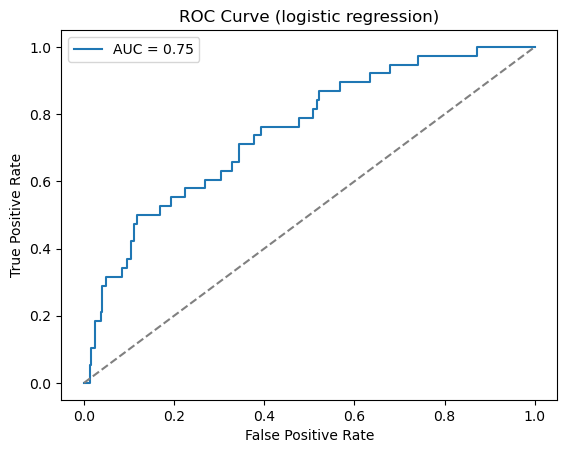

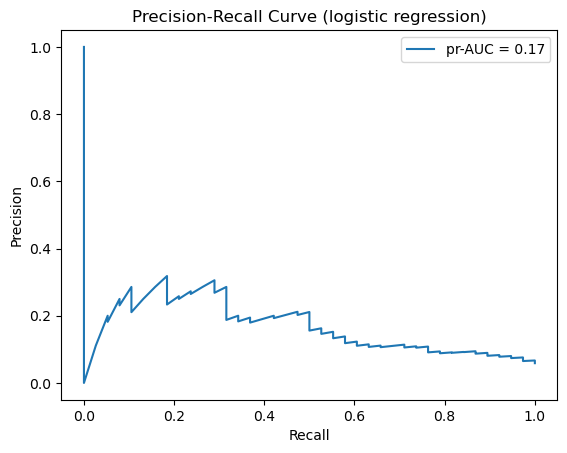

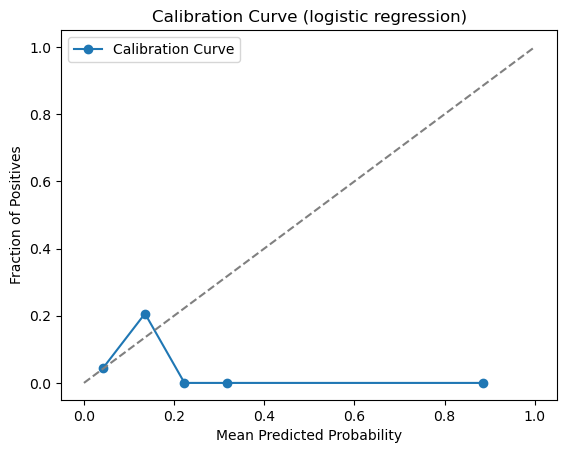

In [14]:
pipeline = make_pipeline(SimpleImputer(strategy='mean'), LogisticRegression(random_state=42))

# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict probabilities on the test set
y_test_prob = pipeline.predict_proba(X_test)[:, 1]

# AUC
auc_score = roc_auc_score(y_test, y_test_prob)
print(f'AUC: {auc_score}')

# pr-AUC
pr_auc_score = average_precision_score(y_test, y_test_prob)
print(f'pr-AUC: {pr_auc_score}')

# MCC Score
mcc = matthews_corrcoef(y_test, (y_test_prob > 0.5).astype(int))
print(f'MCC Score: {mcc:.2f}')

# AIC and BIC
n = X_train.shape[0]  # Number of samples
p = X_train.shape[1] + 1  # Number of features + intercept
log_likelihood = log_loss(y_test, y_test_prob)

# AIC and BIC formulas
aic = 2 * p - 2 * log_likelihood
bic = n * np.log(log_likelihood / n) + p * np.log(n)

print(f'AIC: {aic:.2f}')
print(f'BIC: {bic:.2f}')

threshold = 0.5

# Probabilities to binary predictions
y_test_pred_binary = (y_test_prob > threshold).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_test_pred_binary)
print(f'Accuracy: {accuracy:.2f}')

# F1 score
f1 = f1_score(y_test, y_test_pred_binary)
print(f'F1 Score: {f1:.2f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)
print(f'Confusion Matrix:\n{conf_matrix}')

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (logistic regression)')
plt.legend()
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
plt.figure()
plt.plot(recall, precision, label=f'pr-AUC = {pr_auc_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (logistic regression)')
plt.legend()
plt.show()

# Calibration curve
prob_pos = pipeline.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.figure()
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (logistic regression)')
plt.legend()
plt.show()

In [15]:
pipeline = make_pipeline(SimpleImputer(strategy='mean'), LogisticRegression(random_state=42))
pipeline.fit(X_train, y_train)

# Get coefficients and feature names
coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = X_train.columns

# Create a DataFrame with coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Add absolute coefficients for sorting
coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])

# Sort variables by absolute coefficient in descending order
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Top 10 variables of importance
top_10_variables = coefficients_df.head(10)
print("Top 10 Variables of Importance:")
print(top_10_variables)

# Compute odds ratios for the top 10 variables
top_10_variables['Odds_Ratio'] = np.exp(top_10_variables['Coefficient'])
print("\nOdds Ratios for Top 10 Variables:")
print(top_10_variables[['Feature', 'Odds_Ratio']])

Top 10 Variables of Importance:
                                         Feature  Coefficient  Abs_Coefficient
9                                     INR(PT)_NA     0.240191         0.240191
18                            grouped_race_White     0.227999         0.227999
25  COPD (Chronic Obstructive Pulmonary)_Present     0.149496         0.149496
15                            grouped_race_Black    -0.139962         0.139962
22             PVD (Peripheral Vascular)_Present     0.123011         0.123011
11                               Potassium_mEq/L     0.113716         0.113716
32                            RD (Renal)_Present     0.104804         0.104804
7                               Creatinine_mg/dL     0.102462         0.102462
35                     Metastatic Cancer_Present     0.094573         0.094573
33                                Cancer_Present     0.081300         0.081300

Odds Ratios for Top 10 Variables:
                                         Feature  Odds_Ratio
9  

* #### The Lasso

AUC (Lasso): 0.77
pr-AUC (Lasso): 0.17
MCC Score (Lasso): -0.01
AIC (Lasso): 55.60
BIC (Lasso): -24306.18
Accuracy (Lasso): 0.94
F1 Score (Lasso): 0.00
Confusion Matrix (Lasso):
[[608   1]
 [ 38   0]]


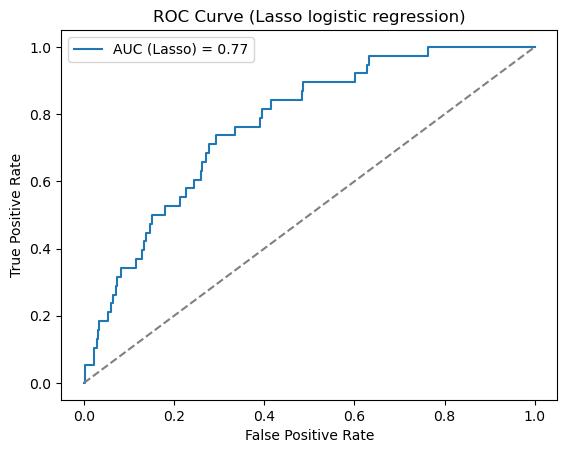

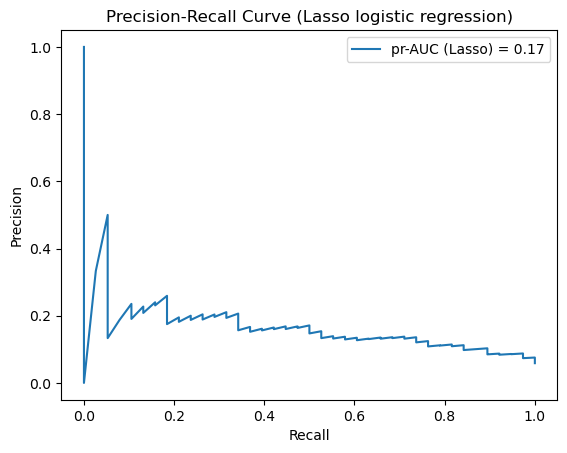

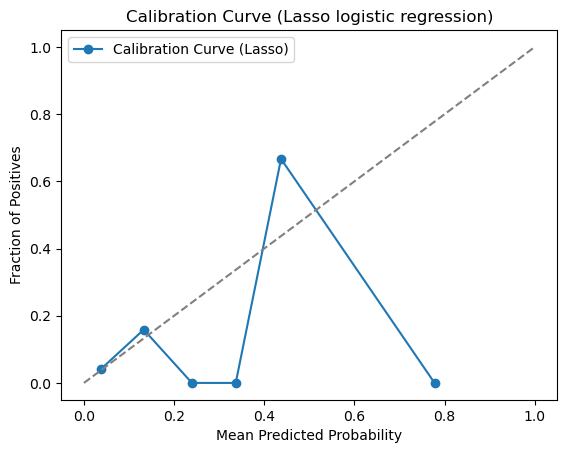

In [16]:
# Create a pipeline with Lasso Logistic Regression
lasso_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
)

# Fit the Lasso Logistic Regression model on the training data
lasso_pipeline.fit(X_train, y_train)

# Predict probabilities on the test set
y_test_prob_lasso = lasso_pipeline.predict_proba(X_test)[:, 1]

# AUC
auc_score_lasso = roc_auc_score(y_test, y_test_prob_lasso)
print(f'AUC (Lasso): {auc_score_lasso:.2f}')

# pr-AUC
pr_auc_score_lasso = average_precision_score(y_test, y_test_prob_lasso)
print(f'pr-AUC (Lasso): {pr_auc_score_lasso:.2f}')

# MCC Score
mcc_lasso = matthews_corrcoef(y_test, (y_test_prob_lasso > 0.5).astype(int))
print(f'MCC Score (Lasso): {mcc_lasso:.2f}')

# AIC and BIC
log_likelihood_lasso = log_loss(y_test, y_test_prob_lasso)

# AIC and BIC formulas
aic_lasso = 2 * (np.sum(lasso_pipeline.named_steps['logisticregression'].coef_ != 0)) - 2 * log_likelihood_lasso
bic_lasso = n * np.log(log_likelihood_lasso / n) + (np.sum(lasso_pipeline.named_steps['logisticregression'].coef_ != 0)) * np.log(n)

print(f'AIC (Lasso): {aic_lasso:.2f}')
print(f'BIC (Lasso): {bic_lasso:.2f}')

threshold_lasso = 0.5

# Probabilities to binary predictions
y_test_pred_binary_lasso = (y_test_prob_lasso > threshold_lasso).astype(int)

# Accuracy
accuracy_lasso = accuracy_score(y_test, y_test_pred_binary_lasso)
print(f'Accuracy (Lasso): {accuracy_lasso:.2f}')

# F1 score
f1_lasso = f1_score(y_test, y_test_pred_binary_lasso)
print(f'F1 Score (Lasso): {f1_lasso:.2f}')

# Confusion matrix
conf_matrix_lasso = confusion_matrix(y_test, y_test_pred_binary_lasso)
print(f'Confusion Matrix (Lasso):\n{conf_matrix_lasso}')

# ROC curve
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_test_prob_lasso)
plt.figure()
plt.plot(fpr_lasso, tpr_lasso, label=f'AUC (Lasso) = {auc_score_lasso:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Lasso logistic regression)')
plt.legend()
plt.show()

# Precision-Recall curve
precision_lasso, recall_lasso, _ = precision_recall_curve(y_test, y_test_prob_lasso)
plt.figure()
plt.plot(recall_lasso, precision_lasso, label=f'pr-AUC (Lasso) = {pr_auc_score_lasso:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Lasso logistic regression)')
plt.legend()
plt.show()

# Calibration curve
prob_pos_lasso = lasso_pipeline.predict_proba(X_test)[:, 1]
fraction_of_positives_lasso, mean_predicted_value_lasso = calibration_curve(y_test, prob_pos_lasso, n_bins=10)
plt.figure()
plt.plot(mean_predicted_value_lasso, fraction_of_positives_lasso, marker='o', label='Calibration Curve (Lasso)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Lasso logistic regression)')
plt.legend()
plt.show()

* #### XGBoost

AUC (XGBoost): 0.73
pr-AUC (XGBoost): 0.21
MCC Score (XGBoost): 0.15
AIC: 73.44
BIC: -23364.90
Accuracy (XGBoost): 0.94
F1 Score (XGBoost): 0.10
Confusion Matrix (XGBoost):
[[607   2]
 [ 36   2]]


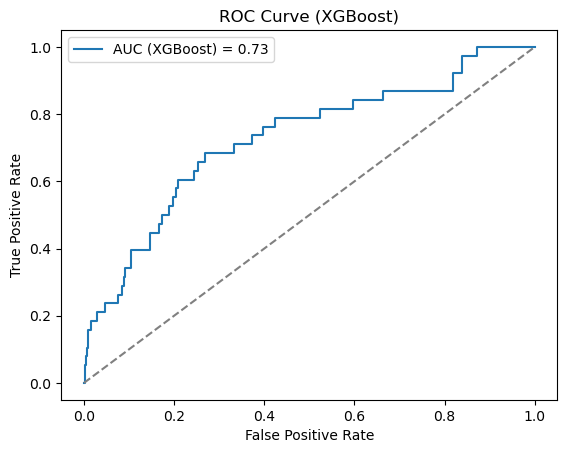

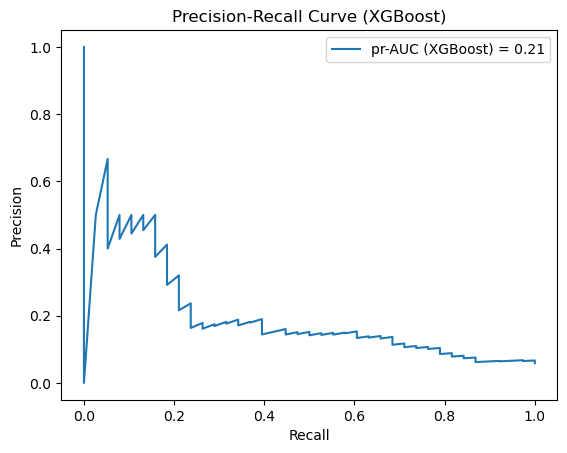

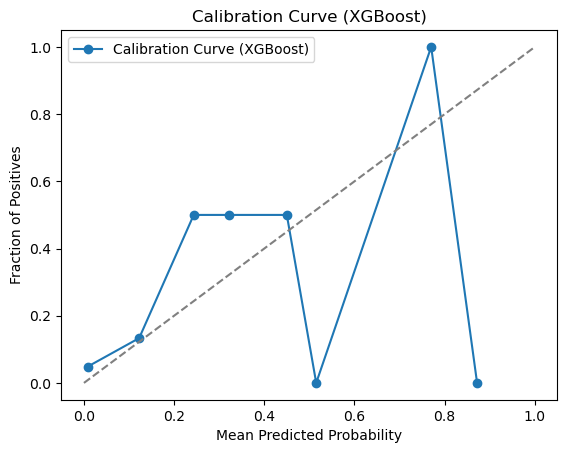

In [17]:
import xgboost as xgb

# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)

# Predict probabilities on the test set
y_test_prob_xgb = xgb_classifier.predict_proba(X_test)[:, 1]

# AUC
auc_score_xgb = roc_auc_score(y_test, y_test_prob_xgb)
print(f'AUC (XGBoost): {auc_score_xgb:.2f}')

# pr-AUC
pr_auc_score_xgb = average_precision_score(y_test, y_test_prob_xgb)
print(f'pr-AUC (XGBoost): {pr_auc_score_xgb:.2f}')

# MCC Score
mcc_xgb = matthews_corrcoef(y_test, (y_test_prob_xgb > 0.5).astype(int))
print(f'MCC Score (XGBoost): {mcc_xgb:.2f}')

# AIC and BIC
n_xgb = X_train.shape[0]
p_xgb = X_train.shape[1] + 1
log_likelihood_xgb = log_loss(y_test, y_test_prob_xgb)

# AIC and BIC formulas
aic_xgb = 2 * p_xgb - 2 * log_likelihood_xgb
bic_xgb = n_xgb * np.log(log_likelihood_xgb / n_xgb) + p_xgb * np.log(n_xgb)

print(f'AIC: {aic_xgb:.2f}')
print(f'BIC: {bic_xgb:.2f}')

threshold_xgb = 0.5

# Probabilities to binary predictions
y_test_pred_binary_xgb = (y_test_prob_xgb > threshold_xgb).astype(int)

# Accuracy
accuracy_xgb = accuracy_score(y_test, y_test_pred_binary_xgb)
print(f'Accuracy (XGBoost): {accuracy_xgb:.2f}')

# F1 score
f1_xgb = f1_score(y_test, y_test_pred_binary_xgb)
print(f'F1 Score (XGBoost): {f1_xgb:.2f}')

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_test_pred_binary_xgb)
print(f'Confusion Matrix (XGBoost):\n{conf_matrix_xgb}')

# ROC curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_prob_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'AUC (XGBoost) = {auc_score_xgb:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.legend()
plt.show()

# Precision-Recall curve
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_test_prob_xgb)
plt.figure()
plt.plot(recall_xgb, precision_xgb, label=f'pr-AUC (XGBoost) = {pr_auc_score_xgb:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (XGBoost)')
plt.legend()
plt.show()

# Calibration curve
prob_pos_xgb = xgb_classifier.predict_proba(X_test)[:, 1]
fraction_of_positives_xgb, mean_predicted_value_xgb = calibration_curve(y_test, prob_pos_xgb, n_bins=10)
plt.figure()
plt.plot(mean_predicted_value_xgb, fraction_of_positives_xgb, marker='o', label='Calibration Curve (XGBoost)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (XGBoost)')
plt.legend()
plt.show()

* #### Random forest

AUC (Random Forest): 0.78
pr-AUC (Random Forest): 0.24
MCC Score (Random Forest): 0.00
AIC: 73.52
BIC: -23740.07
Accuracy (Random Forest): 0.94
F1 Score (Random Forest): 0.00
Confusion Matrix (Random Forest):
[[609   0]
 [ 38   0]]


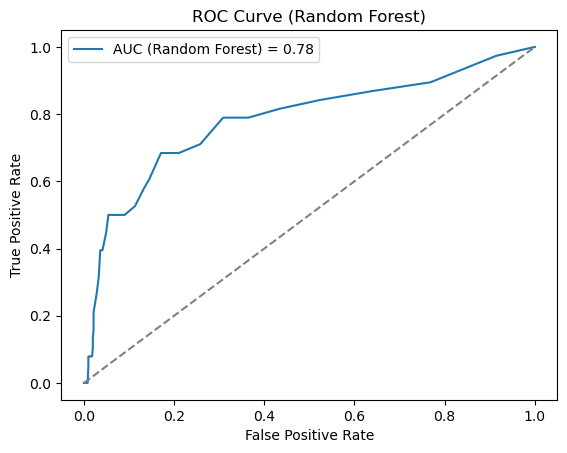

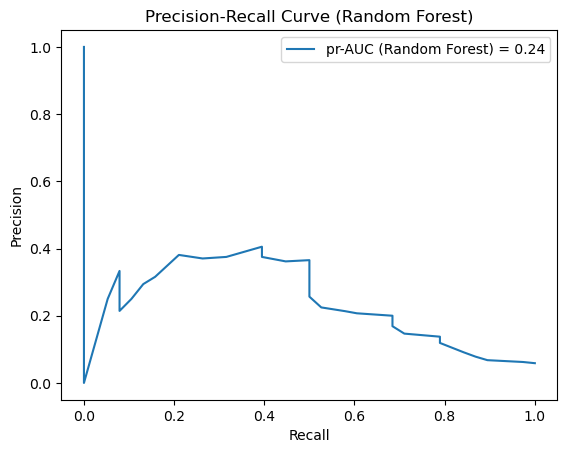

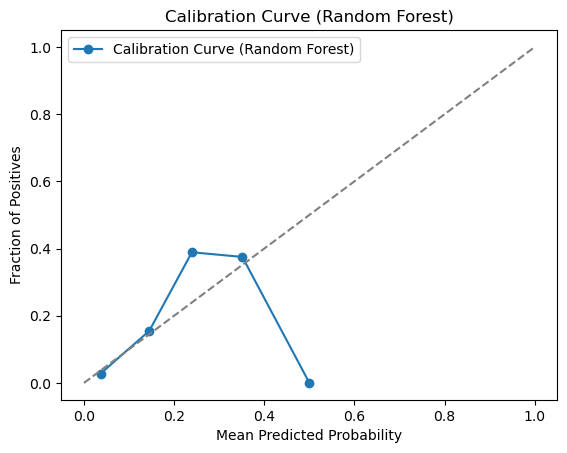

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Preprocessing pipeline with imputation for NaN values
pipeline_rf = make_pipeline(SimpleImputer(strategy='mean'), RandomForestClassifier(random_state=42))

# Fit the Random Forest model on the training data
pipeline_rf.fit(X_train, y_train)

# Predict probabilities on the test set
y_test_prob_rf = pipeline_rf.predict_proba(X_test)[:, 1]

# AUC
auc_score_rf = roc_auc_score(y_test, y_test_prob_rf)
print(f'AUC (Random Forest): {auc_score_rf:.2f}')

# pr-AUC
pr_auc_score_rf = average_precision_score(y_test, y_test_prob_rf)
print(f'pr-AUC (Random Forest): {pr_auc_score_rf:.2f}')

# MCC Score
mcc_rf = matthews_corrcoef(y_test, (y_test_prob_rf > 0.5).astype(int))
print(f'MCC Score (Random Forest): {mcc_rf:.2f}')

# AIC and BIC
n_rf = X_train.shape[0]
p_rf = X_train.shape[1] + 1
log_likelihood_rf = log_loss(y_test, y_test_prob_rf)

# AIC and BIC formulas
aic_rf = 2 * p_rf - 2 * log_likelihood_rf
bic_rf = n_rf * np.log(log_likelihood_rf / n_rf) + p_rf * np.log(n_rf)

print(f'AIC: {aic_rf:.2f}')
print(f'BIC: {bic_rf:.2f}')

threshold_rf = 0.5

# Probabilities to binary predictions
y_test_pred_binary_rf = (y_test_prob_rf > threshold_rf).astype(int)

# Accuracy
accuracy_rf = accuracy_score(y_test, y_test_pred_binary_rf)
print(f'Accuracy (Random Forest): {accuracy_rf:.2f}')

# F1 score
f1_rf = f1_score(y_test, y_test_pred_binary_rf)
print(f'F1 Score (Random Forest): {f1_rf:.2f}')

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_binary_rf)
print(f'Confusion Matrix (Random Forest):\n{conf_matrix_rf}')

# ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_prob_rf)
plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f'AUC (Random Forest) = {auc_score_rf:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend()
plt.show()

# Precision-Recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_test_prob_rf)
plt.figure()
plt.plot(recall_rf, precision_rf, label=f'pr-AUC (Random Forest) = {pr_auc_score_rf:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Random Forest)')
plt.legend()
plt.show()

# Calibration curve
prob_pos_rf = pipeline_rf.predict_proba(X_test)[:, 1]
fraction_of_positives_rf, mean_predicted_value_rf = calibration_curve(y_test, prob_pos_rf, n_bins=10)
plt.figure()
plt.plot(mean_predicted_value_rf, fraction_of_positives_rf, marker='o', label='Calibration Curve (Random Forest)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Random Forest)')
plt.legend()
plt.show()

* #### KNN

AUC: 0.54
pr-AUC: 0.06
MCC Score: -0.01
AIC: 70.93
BIC: -18939.91
Accuracy: 0.94
F1 Score: 0.00
Confusion Matrix:
[[608   1]
 [ 38   0]]


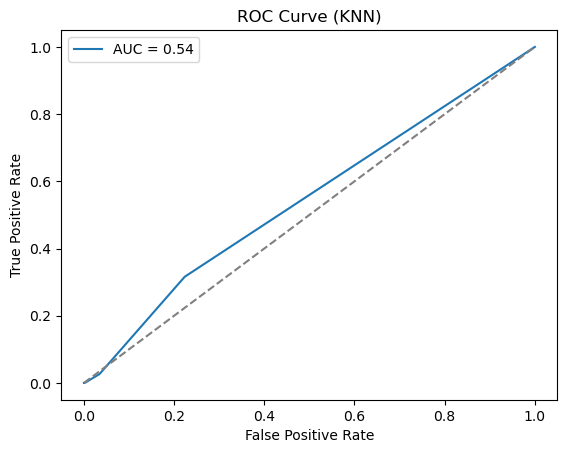

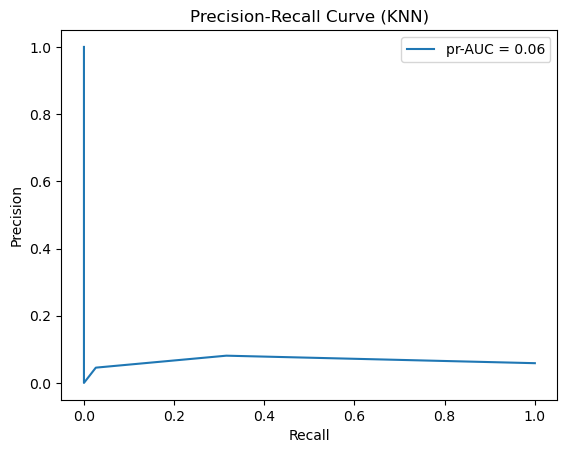

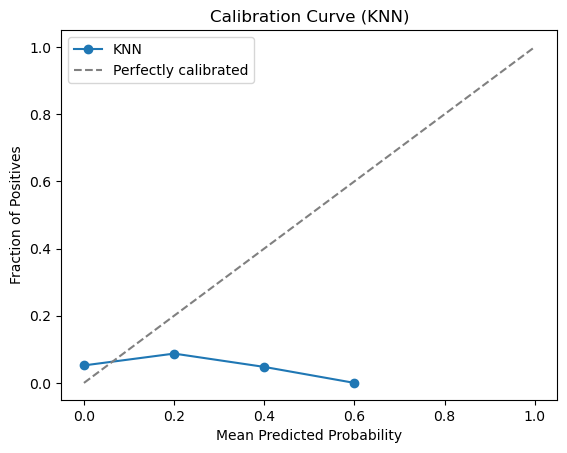

In [19]:
from sklearn.neighbors import KNeighborsClassifier

# Preprocessing pipeline with imputation for NaN values
pipeline_knn = make_pipeline(SimpleImputer(strategy='mean'), KNeighborsClassifier())

# Fit the KNN model on the training data
pipeline_knn.fit(X_train, y_train)

# Predict probabilities on the test set
y_test_prob_knn = pipeline_knn.predict_proba(X_test)[:, 1]

# AUC
auc_score_knn = roc_auc_score(y_test, y_test_prob_knn)
print(f'AUC: {auc_score_knn:.2f}')

# pr-AUC
pr_auc_score_knn = average_precision_score(y_test, y_test_prob_knn)
print(f'pr-AUC: {pr_auc_score_knn:.2f}')

# MCC Score
mcc_knn = matthews_corrcoef(y_test, (y_test_prob_knn > 0.5).astype(int))
print(f'MCC Score: {mcc_knn:.2f}')

# AIC and BIC
n_knn = X_train.shape[0]
p_knn = X_train.shape[1] + 1
log_likelihood_knn = log_loss(y_test, y_test_prob_knn)

# AIC and BIC formulas
aic_knn = 2 * p_knn - 2 * log_likelihood_knn
bic_knn = n_knn * np.log(log_likelihood_knn / n_knn) + p_knn * np.log(n_knn)

print(f'AIC: {aic_knn:.2f}')
print(f'BIC: {bic_knn:.2f}')

threshold_knn = 0.5

# Probabilities to binary predictions
y_test_pred_binary_knn = (y_test_prob_knn > threshold_knn).astype(int)

# Accuracy
accuracy_knn = accuracy_score(y_test, y_test_pred_binary_knn)
print(f'Accuracy: {accuracy_knn:.2f}')

# F1 score
f1_knn = f1_score(y_test, y_test_pred_binary_knn)
print(f'F1 Score: {f1_knn:.2f}')

# Confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_test_pred_binary_knn)
print(f'Confusion Matrix:\n{conf_matrix_knn}')

# ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_test_prob_knn)
plt.figure()
plt.plot(fpr_knn, tpr_knn, label=f'AUC = {auc_score_knn:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN)')
plt.legend()
plt.show()

# Precision-Recall curve
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_test_prob_knn)
plt.figure()
plt.plot(recall_knn, precision_knn, label=f'pr-AUC = {pr_auc_score_knn:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (KNN)')
plt.legend()
plt.show()

prob_true_knn, prob_pred_knn = calibration_curve(y_test, y_test_prob_knn, n_bins=10, strategy='uniform')

# Plot calibration curve
plt.figure()
plt.plot(prob_pred_knn, prob_true_knn, marker='o', linestyle='-', label='KNN')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (KNN)')
plt.legend()
plt.show()

* #### Simple ANN

In [20]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_acc:.2f}')

# Make predictions on the test set
predictions = model.predict(X_test_scaled)

threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, binary_predictions)
print(f'Accuracy: {accuracy:.2f}')

# F1 Score
f1 = f1_score(y_test, binary_predictions)
print(f'F1 Score: {f1:.2f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, binary_predictions)
print(f'Confusion Matrix:\n{conf_matrix}')

# MCC Score
mcc_ann = matthews_corrcoef(y_test, binary_predictions)
print(f'MCC Score (ANN): {mcc_ann:.2f}')

# Make predictions on the test set
predictions = model.predict(X_test_scaled).flatten()  # Flatten predictions to make them 1-dimensional

# Calculate AIC and BIC
n_samples = len(y_test)
log_likelihood = -0.5 * n_samples * np.log(2 * np.pi) - 0.5 * np.sum((predictions - y_test) ** 2) / n_samples

# Number of parameters in the model
n_params = sum([np.prod(w.shape) for w in model.trainable_variables])

# AIC and BIC
aic = -2 * log_likelihood + 2 * n_params
bic = -2 * log_likelihood + n_params * np.log(n_samples)

print(f'AIC: {aic:.2f}')
print(f'BIC: {bic:.2f}')

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, predictions)
auc_score = roc_auc_score(y_test, predictions)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Neural Network)')
plt.legend()
plt.show()

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, predictions)
plt.figure()
plt.plot(recall, precision, label=f'pr-AUC = {average_precision_score(y_test, predictions):.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Neural Network)')
plt.legend()
plt.show()

# Calibration curve
prob_true_ann, prob_pred_ann = calibration_curve(y_test, predictions, n_bins=10, strategy='uniform')
plt.figure()
plt.plot(prob_pred_ann, prob_true_ann, marker='o', linestyle='-', label='Neural Network')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Neural Network)')
plt.legend()
plt.show()

Epoch 1/10
65/65 [==============================] - 1s 4ms/step - loss: nan - accuracy: 0.9372 - val_loss: nan - val_accuracy: 0.9556
Epoch 2/10
65/65 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.9406 - val_loss: nan - val_accuracy: 0.9556
Epoch 3/10
65/65 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9406 - val_loss: nan - val_accuracy: 0.9556
Epoch 4/10
65/65 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9406 - val_loss: nan - val_accuracy: 0.9556
Epoch 5/10
65/65 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.9406 - val_loss: nan - val_accuracy: 0.9556
Epoch 6/10
65/65 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.9406 - val_loss: nan - val_accuracy: 0.9556
Epoch 7/10
65/65 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.9406 - val_loss: nan - val_accuracy: 0.9556
Epoch 8/10
65/65 [==============================] - 0s 1ms/ste

ValueError: Input contains NaN.

# SHAP Analysis

In [21]:
# Get coefficients and feature names
coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = X_train.columns

# Create a DataFrame with coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Compute odds ratios for all variables
coefficients_df['Odds_Ratio'] = np.exp(coefficients_df['Coefficient'])

# Display the DataFrame with odds ratios
print("Odds Ratios for All Variables:")
print(coefficients_df[['Feature', 'Odds_Ratio']])

Odds Ratios for All Variables:
                                         Feature  Odds_Ratio
0                                  age_admission    1.057633
1                                    temperature    1.005034
2                                      heartrate    1.009307
3                                          o2sat    0.993194
4                                            sbp    0.991084
5                                    BMI (kg/m2)    1.000022
6                              Bicarbonate_mEq/L    0.988213
7                               Creatinine_mg/dL    1.107895
8                                Hemoglobin_g/dL    0.956023
9                                     INR(PT)_NA    1.271492
10                           Platelet Count_K/uL    0.998958
11                               Potassium_mEq/L    1.120434
12                                WBC Count_K/uL    1.038017
13                                  Sodium_mEq/L    0.948387
14                            grouped_race_Asian    0.

In [22]:
# Compute odds ratios for the top 10 variables
top_10_variables['Odds_Ratio'] = np.exp(top_10_variables['Coefficient'])
print("\nOdds Ratios for Top 10 Variables:")
print(top_10_variables[['Feature', 'Odds_Ratio']])


Odds Ratios for Top 10 Variables:
                                         Feature  Odds_Ratio
9                                     INR(PT)_NA    1.271492
18                            grouped_race_White    1.256084
25  COPD (Chronic Obstructive Pulmonary)_Present    1.161249
15                            grouped_race_Black    0.869392
22             PVD (Peripheral Vascular)_Present    1.130896
11                               Potassium_mEq/L    1.120434
32                            RD (Renal)_Present    1.110493
7                               Creatinine_mg/dL    1.107895
35                     Metastatic Cancer_Present    1.099189
33                                Cancer_Present    1.084696


In [23]:
# Train the XGBoost model
xgb_classifier.fit(X_train, y_train)

# Create a SHAP explainer for the XGBoost model
explainer_bst = shap.TreeExplainer(xgb_classifier)

# Calculate SHAP values for the test set
shap_values_bst = explainer_bst.shap_values(X_test)

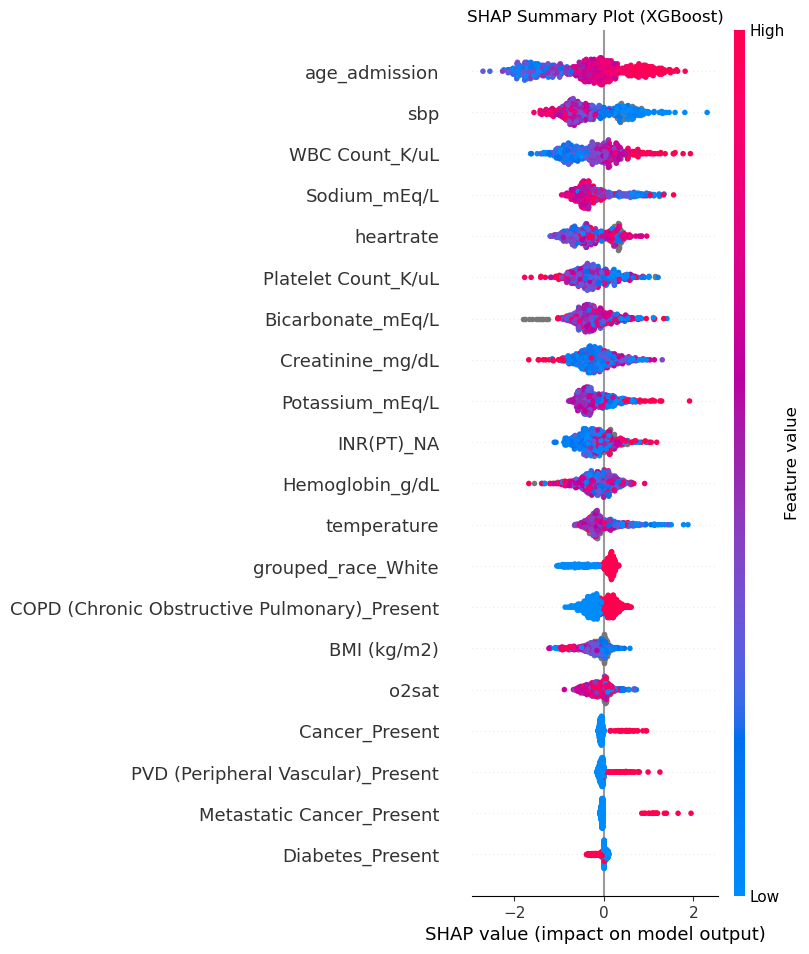

In [24]:
# Create a summary plot
shap.summary_plot(shap_values_bst, X_test, show=False)
plt.title('SHAP Summary Plot (XGBoost)')
plt.show()

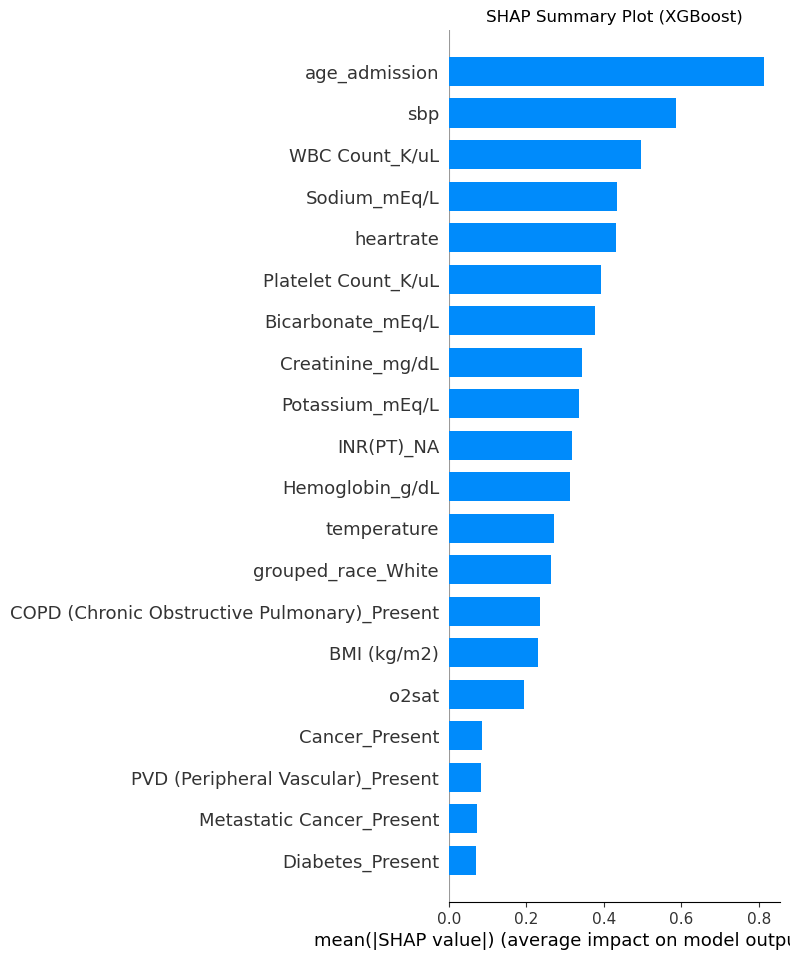

In [25]:
# Create a summary plot
shap.summary_plot(shap_values_bst, X_test, plot_type="bar", show=False)
plt.title('SHAP Summary Plot (XGBoost)')
plt.show()

In [26]:
shap.initjs()

In [27]:
shap.force_plot(explainer_bst.expected_value, shap_values_bst[0, :], X_test.iloc[0, :])

In [28]:
shap.force_plot(explainer_bst.expected_value, shap_values_bst[1, :], X_test.iloc[1, :])

In [29]:
shap.force_plot(explainer_bst.expected_value, shap_values_bst[2, :], X_test.iloc[2, :])

In [30]:
shap.force_plot(explainer_bst.expected_value, shap_values_bst[3, :], X_test.iloc[3, :])

In [31]:
shap.force_plot(explainer_bst.expected_value, shap_values_bst[4, :], X_test.iloc[4, :])

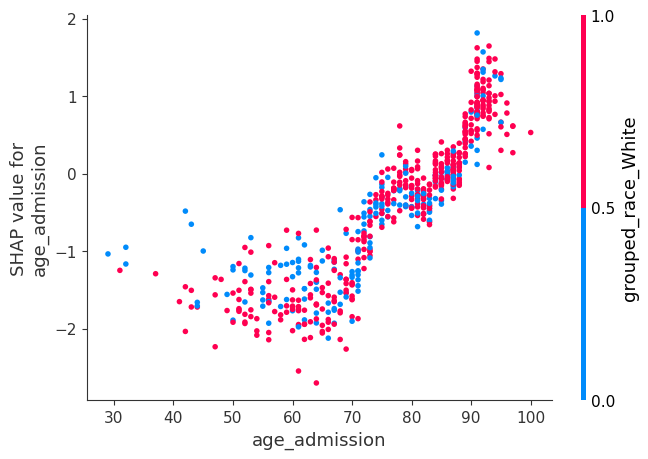

In [32]:
shap.dependence_plot("age_admission", shap_values_bst, X_test)